## Moving the Real-Time Datastream into a File

There are two parts to a NF experiment - usually: the calibration measurement (for which we don't need to do anything real-time), and then after that -- the real-time application of a spatial filter. 

Before everything else though, we might wish to collect the incoming data stream and then save that to disk. Then we can just load it back in again. how to do that, is with a python module called dynarray. It's an array that can grow dynamically (while numpy's array are usually fixed-length)

In [1]:
import pylsl
import mne
import sys
import time

But we also need to be able to 'grow' an array - see [dynarray](https://github.com/maciejkula/dynarray)

In [2]:
import dynarray
import numpy as np

So in order to proceed, start first the example data data stream by running the code in [2_2_SignalPlayback.ipynb](2_2_SignalPlayback.ipynb); then collect data for about 5 minutes, and save it to disk; we inspect it then to figure out where we can get some nice eyeblinks.

In [3]:
streams=pylsl.resolve_streams()

In [4]:
streams

In [5]:
inlet=pylsl.stream_inlet(streams[0])
inlet_info = inlet.info()
nchans = inlet_info.channel_count()
srate = inlet_info.nominal_srate()

extracting the channel names is a bit more challenging as per shown [here](https://github.com/labstreaminglayer/liblsl-Python/blob/master/pylsl/examples/HandleMetadata.py) (lines 40 and above)

In [6]:
channel_names=[]
ch = inlet_info.desc().child("channels").child("channel")
for k in range(inlet_info.channel_count()):
    print("  " + ch.child_value("label"))
    channel_names.append(ch.child_value("label"))
    ch = ch.next_sibling()

  Fp1
  Fp2
  C3
  C4
  T5
  T6
  O1
  O2
  F7
  F8
  F3
  F4
  T3
  T4
  P3
  P4


In [7]:
sys.path.append("/home/nfcontrol/nf/nfb")
sys.path.append("/home/nfcontrol/nf/nfb/pynfb")

import widgets
from widgets.signal_viewers import SignalViewer
from widgets.signal_viewers import RawSignalViewer

import widgets


In [8]:
# make the RawSignalViewer with that many channels
from PyQt5 import QtGui, QtWidgets
app = QtWidgets.QApplication(sys.argv)

In [9]:
w=RawSignalViewer(srate,['%d' % i for i in range(nchans)])

/home/nfcontrol/nf/nfb/pynfb/static/imag/right-arrow.png
/home/nfcontrol/nf/nfb/pynfb/static/imag/left-arrow.png


In [12]:
w.show()

In [11]:
imcoming_data = dynarray.DynamicArray((None, nchans))
begin_time = time.time()
while time.time() - begin_time < 60*3:  # we run for 5 minutes...
    
    data_chunk, times = inlet.pull_chunk()
    
    if data_chunk:
        
        imcoming_data.extend(data_chunk)  # and accumulate data...
        w.update(data_chunk)


KeyboardInterrupt: 

In [10]:
w.close()

In [11]:
imcoming_data.shrink_to_fit()

In [12]:
imcoming_data.shape

(179975, 13)

In [13]:
# we need to transpose it to make it into MNE Python
data_for_mne = np.transpose(imcoming_data)

In [14]:
data_for_mne.shape

(13, 179975)

MNE Python gives us a way to make this into an MNE Format in their [example](https://mne.tools/dev/auto_examples/io/plot_objects_from_arrays.html):



In [18]:
channel_names

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'C3',
 'Cz',
 'C4',
 'P3',
 'Pz',
 'P4',
 'O1',
 'O2',
 'Oz']

In [19]:
ch_types = ['eeg' for i in range(nchans)]

In [22]:
# we also need to specify a montage otherwise it won't know channel position.
# channel positions are:
montage=mne.channels.make_standard_montage('standard_1020')

In [23]:
info = mne.create_info(ch_names=channel_names, montage=montage, sfreq=srate, ch_types=ch_types)

DigMontage is a superset of info. 81 in DigMontage will be ignored. The ignored channels are: {'AF9', 'F9', 'CP4', 'AF8', 'P7', 'PO7', 'AF1', 'FT10', 'PO9', 'FC5', 'F7', 'FC4', 'AF10', 'F2', 'PO3', 'AF7', 'FC3', 'TP9', 'F8', 'AF2', 'AF6', 'Fz', 'O9', 'Iz', 'F10', 'T6', 'PO10', 'TP7', 'FT9', 'CPz', 'AF5', 'F6', 'FT8', 'C1', 'CP2', 'P9', 'P1', 'P8', 'CP6', 'M1', 'T9', 'C2', 'P6', 'FC1', 'FT7', 'CP3', 'AF4', 'T3', 'AFz', 'F1', 'P10', 'CP5', 'T5', 'TP10', 'PO2', 'POz', 'T7', 'T10', 'PO5', 'PO6', 'C6', 'C5', 'PO8', 'PO1', 'FC2', 'Fpz', 'TP8', 'A2', 'AF3', 'T8', 'CP1', 'O10', 'M2', 'A1', 'P5', 'FC6', 'T4', 'F5', 'PO4', 'P2', 'FCz'}


In [24]:
raw = mne.io.RawArray(data_for_mne, info)

Creating RawArray with float64 data, n_channels=13, n_times=179975
    Range : 0 ... 179974 =      0.000 ...   179.974 secs
Ready.


Now that we have it - we can plot it! - but in order to do so, we must first do 
```python
%matplotlib qt
```


In [25]:
%matplotlib qt

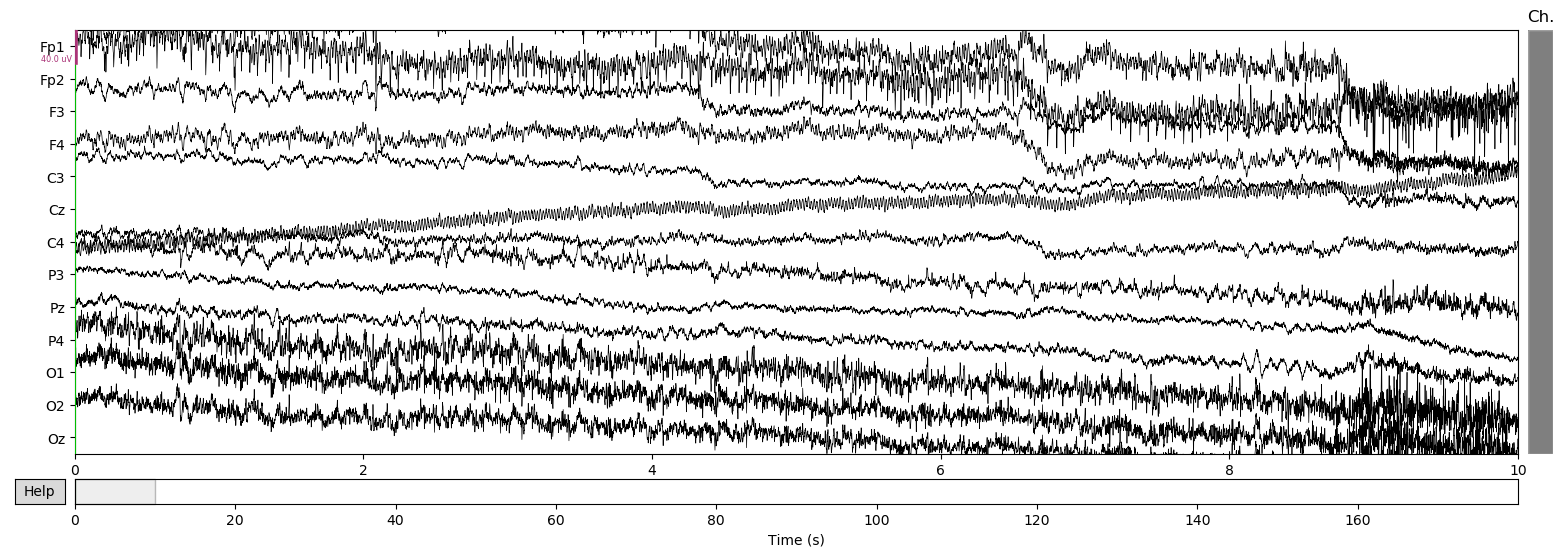

In [26]:
raw.plot()

also, we can save this file to disk... using MNE's save functionality mentioned [here](https://mne.tools/stable/auto_examples/io/plot_read_and_write_raw_data.html)
-- it uses its own .fif data format, which is a thing from the MEG world

In [28]:
raw.save('savedfiles/example.fif', overwrite=True)

Overwriting existing file.
Writing /home/rt/nf/nf-rtime/Tutorials/savedfiles/example.fif


<ipython-input-28-cbf8975db520>:1: RuntimeWarning: This filename (/home/rt/nf/nf-rtime/Tutorials/savedfiles/example.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw.save('savedfiles/example.fif', overwrite=True)


Closing /home/rt/nf/nf-rtime/Tutorials/savedfiles/example.fif [done]


You get a few warnings, but it is fine